# AXA Coding Challenge
Author: Jonas Mickel

# Imports & Globals

In [85]:
#system
import re
import os
import zipfile
from io import BytesIO
from glob import glob
from datetime import date
from typing import Dict, List, Tuple

#3rd party
import boto3
import folium
import numpy as np
import polars as pl
import pandas as pd 
import geopandas as gpd
import xgboost as xgb

from botocore.client import Config
from botocore import UNSIGNED

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

from folium.plugins import HeatMap

from citibike_utils import *

SEED=2024
YEAR_OF_INTEREST=2024

pl.enable_string_cache()

## Load 2024 trip data from s3

In [86]:
s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
BUCKET_NAME = 'tripdata'
response = s3.list_objects_v2(Bucket=BUCKET_NAME)

if 'Contents' in response:
    filtered_trip_data = [obj['Key'] for obj in response['Contents'] if re.search(rf'{YEAR_OF_INTEREST}', obj['Key'])]

In [87]:
filtered_trip_data

['202401-citibike-tripdata.csv.zip',
 '202402-citibike-tripdata.csv.zip',
 '202403-citibike-tripdata.csv.zip',
 '202404-citibike-tripdata.csv.zip',
 '202405-citibike-tripdata.zip',
 '202406-citibike-tripdata.zip',
 '202407-citibike-tripdata.zip',
 '202408-citibike-tripdata.zip',
 '202409-citibike-tripdata.zip',
 '202410-citibike-tripdata.zip',
 '202411-citibike-tripdata.zip',
 'JC-202401-citibike-tripdata.csv.zip',
 'JC-202402-citibike-tripdata.csv.zip',
 'JC-202403-citibike-tripdata.csv.zip',
 'JC-202404-citibike-tripdata.csv.zip',
 'JC-202405-citibike-tripdata.csv.zip',
 'JC-202406-citibike-tripdata.csv.zip',
 'JC-202407-citibike-tripdata.csv.zip',
 'JC-202408-citibike-tripdata.csv.zip',
 'JC-202409-citibike-tripdata.csv.zip',
 'JC-202410-citibike-tripdata.csv.zip',
 'JC-202411-citibike-tripdata.csv.zip']

In [88]:
def s3_trip_download(bucket_name: str, file_key: str, path_prefix: str) -> None:
    """
    Downloads CitiBike tripdata to local storage
    """
    key_basename = file_key.split('.')[0]
    if not key_basename in ';'.join(os.listdir(path_prefix)):
        try:
            s3_object = s3.get_object(Bucket=bucket_name, Key=file_key)
        except Exception as e:
            print(e)
            return None
        with zipfile.ZipFile(BytesIO(s3_object['Body'].read())) as z:
            print(z.namelist())
            csv_list = list(filter(lambda x: x.endswith('.csv') and x.startswith(key_basename), z.namelist()))
            for csv in csv_list:
                with z.open(csv) as csv_file:
                    with open(f'{path_prefix}/{os.path.basename(csv)}', 'wb') as f:
                        f.write(csv_file.read())
    
def s3_to_pandas(bucket_name: str, file_key: str, idx: int, nrows: int) -> pd.DataFrame:
    """
    Downloads CitiBike tripdata to pd.DataFrame in memory.
    """
    print(idx, file_key)
    s3_object = s3.get_object(Bucket=bucket_name, Key=file_key)
    with zipfile.ZipFile(BytesIO(s3_object['Body'].read())) as z:
        print(z.namelist())
        csv_list = list(filter(lambda x: x.endswith('.csv') and x.startswith(file_key.split('.')[0]), z.namelist()))
        if csv_list:
            print(csv_list)
            df_list = []
            for csv in csv_list:
                with z.open(csv) as csv_file:
                    df_list.append(pd.read_csv(csv_file, nrows=nrows))
            return pd.concat(df_list)
        else:
            return pd.DataFrame() 

for idx, key in enumerate(filtered_trip_data):
    print(idx, key)
    s3_trip_download(BUCKET_NAME, key, 'data')

0 202401-citibike-tripdata.csv.zip
1 202402-citibike-tripdata.csv.zip
2 202403-citibike-tripdata.csv.zip
3 202404-citibike-tripdata.csv.zip
4 202405-citibike-tripdata.zip
5 202406-citibike-tripdata.zip
6 202407-citibike-tripdata.zip
7 202408-citibike-tripdata.zip
8 202409-citibike-tripdata.zip
9 202410-citibike-tripdata.zip
10 202411-citibike-tripdata.zip
11 JC-202401-citibike-tripdata.csv.zip
12 JC-202402-citibike-tripdata.csv.zip
13 JC-202403-citibike-tripdata.csv.zip
14 JC-202404-citibike-tripdata.csv.zip
15 JC-202405-citibike-tripdata.csv.zip
16 JC-202406-citibike-tripdata.csv.zip
17 JC-202407-citibike-tripdata.csv.zip
18 JC-202408-citibike-tripdata.csv.zip
19 JC-202409-citibike-tripdata.csv.zip
20 JC-202410-citibike-tripdata.csv.zip
21 JC-202411-citibike-tripdata.csv.zip


In [89]:
# read only 100 rows to get a understanding of available columns across files
trip_df_sample = pd.concat([pd.read_csv(csv, nrows=10) for csv in glob(r'data/*tripdata*.csv')])

In [90]:
trip_df_sample.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,Unnamed: 0,rideable_type_duplicate_column_name_1
0,5078F3D302000BD2,electric_bike,2024-01-22 18:43:19.012,2024-01-22 18:48:10.708,Frederick Douglass Blvd & W 145 St,7954.12,St Nicholas Ave & W 126 St,7756.1,40.823072,-73.941738,40.811432,-73.951878,member,NaN,NaN
1,814337105D37302A,electric_bike,2024-01-11 19:19:18.721,2024-01-11 19:47:36.007,W 54 St & 6 Ave,6771.13,E 74 St & 1 Ave,6953.08,40.761822,-73.977036,40.768974,-73.954823,member,NaN,NaN
2,A33A920E2B10710C,electric_bike,2024-01-30 19:17:41.693,2024-01-30 19:32:49.857,E 11 St & Ave B,5659.11,W 10 St & Washington St,5847.06,40.727592,-73.979751,40.733424,-74.008515,casual,NaN,NaN
3,A3A5FC0DD7D34D74,electric_bike,2024-01-27 11:27:01.759,2024-01-27 11:38:01.213,W 54 St & 6 Ave,6771.13,E 74 St & 1 Ave,6953.08,40.761779,-73.977144,40.768974,-73.954823,member,NaN,NaN
4,6F96728ECEFBDAA4,electric_bike,2024-01-16 15:15:41.000,2024-01-16 15:29:26.156,Madison Ave & E 99 St,7443.01,E 74 St & 1 Ave,6953.08,40.789808,-73.952214,40.768974,-73.954823,member,NaN,NaN


In [91]:
trip_df_sample.describe()

,start_lat,start_lng,end_lat,end_lng,Unnamed: 0
count,500.000000,500.000000,500.000000,500.000000,5.000000e+01
mean,40.741408,-73.984444,40.741438,-73.984269,2.000004e+06
std,0.039564,0.041222,0.038429,0.039916,1.428571e+06
min,40.648005,-74.072009,40.637033,-74.071959,0.000000e+00
25%,40.717758,-74.008173,40.719261,-74.008892,1.000002e+06
50%,40.739704,-73.984483,40.739057,-73.985637,2.000004e+06
75%,40.756690,-73.957071,40.757733,-73.957721,3.000007e+06
max,40.875531,-73.859204,40.879350,-73.864540,4.000009e+06


In [92]:
# check if there is mismatched data in columns rideable_type and its duplicate
print(trip_df_sample.rideable_type.value_counts())
print(trip_df_sample.rideable_type_duplicate_column_name_1.value_counts())
trip_df_sample[trip_df_sample.rideable_type_duplicate_column_name_1.notna()].query("""rideable_type_duplicate_column_name_1!=rideable_type""")
# -> can be disregarded, duplicated

rideable_type
electric_bike    355
classic_bike     145
Name: count, dtype: int64
rideable_type_duplicate_column_name_1
electric_bike    32
classic_bike     18
Name: count, dtype: int64


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,Unnamed: 0,rideable_type_duplicate_column_name_1


In [93]:
# check 'unnamed column' 
trip_df_sample.iloc[:,14].value_counts()

rideable_type_duplicate_column_name_1
electric_bike    32
classic_bike     18
Name: count, dtype: int64

In [94]:
trip_df_sample[trip_df_sample.iloc[:,14].notna()]
# seems to be only contained in July entries
# corresponds to row number, data seems to be chunked in files of 1M rows each
# -> can be disregarded

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,Unnamed: 0,rideable_type_duplicate_column_name_1
0,7751B52D3787C04F,classic_bike,2024-08-17 11:42:14.451,2024-08-17 11:55:24.856,5 Ave & E 87 St,7323.09,5 Ave & E 63 St,6904.06,40.782323,-73.959875,40.766368,-73.971518,casual,NaN,classic_bike
1,D55E8D998FAB6749,classic_bike,2024-08-17 11:42:06.786,2024-08-17 11:55:30.094,5 Ave & E 87 St,7323.09,5 Ave & E 63 St,6904.06,40.782323,-73.959875,40.766368,-73.971518,casual,NaN,classic_bike
2,0477812DB65BF3FB,electric_bike,2024-08-22 07:18:43.412,2024-08-22 07:40:48.249,E 53 St & Madison Ave,6659.03,Lenox Ave & W 117 St,7655.22,40.759711,-73.974023,40.802557,-73.949078,casual,NaN,electric_bike
3,E2E8A247831D3463,electric_bike,2024-08-21 17:59:51.350,2024-08-21 18:24:22.388,E 53 St & Madison Ave,6659.03,Lenox Ave & W 130 St,7753.13,40.759711,-73.974023,40.810792,-73.943068,casual,NaN,electric_bike
4,3BA2B12245849ECD,classic_bike,2024-08-23 12:48:30.734,2024-08-23 13:46:11.632,MacDougal St & Washington Sq,5797.01,Lafayette St & Grand St,5422.09,40.732264,-73.998522,40.720280,-73.998790,casual,NaN,classic_bike
5,ADBAD6489631209E,electric_bike,2024-08-27 19:00:01.861,2024-08-27 19:06:41.245,MacDougal St & Washington Sq,5797.01,Lafayette St & Grand St,5422.09,40.732264,-73.998522,40.720280,-73.998790,casual,NaN,electric_bike
6,333B09F497DA03C2,classic_bike,2024-08-31 14:49:04.668,2024-08-31 15:41:46.802,5 Ave & E 87 St,7323.09,5 Ave & E 63 St,6904.06,40.782323,-73.959875,40.766368,-73.971518,casual,NaN,classic_bike
7,80FCD62A5676B480,classic_bike,2024-08-17 11:04:52.140,2024-08-17 11:32:20.506,Broadway & E 19 St,5980.11,5 Ave & E 63 St,6904.06,40.738290,-73.990060,40.766368,-73.971518,casual,NaN,classic_bike
8,87BADD1A40CF4C3A,electric_bike,2024-08-30 19:50:56.103,2024-08-30 20:18:57.562,MacDougal St & Washington Sq,5797.01,Hudson Blvd W & W 36 St,6611.07,40.732264,-73.998522,40.756765,-73.999714,casual,NaN,electric_bike
9,BFB266436E082776,electric_bike,2024-08-20 10:01:53.842,2024-08-20 10:13:12.656,Emerson Pl & Myrtle Ave,4683.02,Fulton St & Adams St,4637.06,40.693631,-73.962236,40.692418,-73.989495,casual,NaN,electric_bike


In [95]:
usable_columns = list(trip_df_sample.drop(columns=['rideable_type_duplicate_column_name_1','Unnamed: 0']).columns)
print(usable_columns)

['ride_id', 'rideable_type', 'started_at', 'ended_at', 'start_station_name', 'start_station_id', 'end_station_name', 'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng', 'member_casual']


# load sample from 2024 data

In [96]:
target_dtypes = {
    'rideable_type': str,
    'start_station_name': str,
    'start_station_id': str,
    'end_station_name': str,
    'end_station_id': str,
    'start_lat': float,
    'start_lng': float,
    'end_lat': float,
    'end_lng': float,
    'member_casual': str,
}

n = 100  # keep only every 20th line = 5% of the lines

# pandas
trip_dfs=[
    pd.read_csv(
        csv,
        usecols=usable_columns[1:],
        dtype=target_dtypes,
        parse_dates=['started_at', 'ended_at'],
        skiprows=lambda i: i % n != 0
    ) for csv in glob('data/*tripdata*.csv')
]

# polars
#trip_df=pl.concat([pl.read_csv(f'tripdata/{csv}', columns=list(usable_columns), infer_schema_length=None, try_parse_dates=True) for csv in os.listdir('tripdata')])

In [97]:
categorical_columns = ['rideable_type', 'start_station_name', 'end_station_name', 'member_casual']
def convert_categoricals(df , col): 
    df[col] = df[col].astype('category')
    return df
trip_dfs = [convert_categoricals(i, categorical_columns) for i in trip_dfs]
trip_dfs = pd.concat(trip_dfs)
trip_dfs.to_parquet('data/subsampled_2024_trip_data.parquet')

# Data cleaning

In [98]:
# Load Parquet file
schema = {
    'rideable_type': pl.Categorical,
    'started_at': pl.Datetime,
    'ended_at': pl.Datetime,
    'start_station_name': pl.Categorical,
    'end_station_name': pl.Categorical,
    'member_casual': pl.Categorical,
}

trip_df = pl.scan_parquet('data/subsampled_2024_trip_data.parquet').cast(schema)

In [99]:
trip_df.null_count().collect()

rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,__index_level_0__
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,309,309,1121,1192,0,0,108,108,0,0


In [100]:
# Calculate the number of unique values per column
unique_counts = trip_df.select([pl.col(c).n_unique().alias(c) for c in trip_df.columns])

# Collect the results
result = unique_counts.collect()

/tmp/ipykernel_33174/2609663230.py:2: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  unique_counts = trip_df.select([pl.col(c).n_unique().alias(c) for c in trip_df.columns])


In [101]:
result

rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,__index_level_0__
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
2,430315,430310,2273,2375,2274,2365,125439,122387,2305,2301,2,32170


Two things become directly visible:

(i) There are entries with missing values in the recorded trip location (only end) and missing values in the station_name columns, likely a result of an erroneous geocoding or gps recording. While one could be re-running the geocoding to potentially recover some of the missing entries, I will simply exclude these entries from the dataset, as they only make up a share of roughly 0.2% of the data and it can be afforded to lose this data.

(ii) Station names are likely a unique identifier as the sets of both start and end stations are of equal size. Latitude and Longitude have more realisations, i.e. they are likely more localised data from a GPS sensor in the phone or bike itself. Station Ids seem to be missing in some instances. 
Let's create a complete mapping of station names and corresponding IDs.


In [102]:
start_stations = trip_df.select(['start_station_name', 'start_station_id']).rename(lambda x: x.replace('start_','')).unique().collect()
end_stations = trip_df.select(['end_station_name', 'end_station_id']).rename(lambda x: x.replace('end_','')).unique().collect()

In [103]:
stations = start_stations.extend(end_stations).unique()
del start_stations, end_stations

In [104]:
stations.group_by('station_name').n_unique().filter(pl.col('station_id')>1).sort('station_id')

station_name,station_id
cat,u32
"""W 211 St & 10 Ave""",2
"""Ave D & E 3 St""",2
"""Mercer St & Spring St""",2
"""W 12 St & Hudson St""",2
"""Amsterdam Ave & W 82 St""",2
…,…
"""N 6 St & Bedford Ave""",3
"""3 Ave & E 71 St""",3
"""Longwood Ave & Southern Blvd""",3


In [105]:
# let's check some of these duplicates
stations.filter(pl.col('station_name').is_in(["31 St & Broadway","Allen St & Hester St"]))
# so there are 3 issues with the station id, (i) missing values, (ii) padded 0 after dezimal as in a float value, (iii) wrong entry. 
# -> use station_name instead

station_name,station_id
cat,str
"""Allen St & Hester St""","""5342.10"""
"""Allen St & Hester St""","""5342.1"""
"""31 St & Broadway""","""6789.20"""
"""Allen St & Hester St""",null
"""Allen St & Hester St""","""5343.1"""
"""Allen St & Hester St""","""5343.10"""
"""31 St & Broadway""","""6789.2"""


In [106]:
trip_df = trip_df.drop(['start_station_id', 'end_station_id']).drop_nulls()

let's check the geospatial data for inconsistencies. 

In [107]:
start_locs = trip_df.select(['start_station_name', 'start_lat', 'start_lng']).rename(lambda x: x.replace('start_',''))
end_locs = trip_df.select(['end_station_name', 'end_lat', 'end_lng']).rename(lambda x: x.replace('end_',''))
locations = pl.concat([start_locs, end_locs])

In [108]:
per_station_locs = locations.group_by('station_name').agg(
    lat_mn = pl.mean('lat'),
    lat_sd = pl.std('lat'),
    lat_min = pl.min('lat'),
    lat_max = pl.max('lat'),
    lng_mn = pl.mean('lng'),
    lng_sd = pl.std('lng'),
    lng_min = pl.min('lng'),
    lng = pl.max('lng'),
).collect()

In [109]:
per_station_locs.sort('lng_sd')

station_name,lat_mn,lat_sd,lat_min,lat_max,lng_mn,lng_sd,lng_min,lng
cat,f64,f64,f64,f64,f64,f64,f64,f64
"""2 Ave & 39 St""",40.655959,null,40.655959,40.655959,-74.009916,null,-74.009916,-74.009916
"""Creston Ave & E 181 St""",40.854969,null,40.854969,40.854969,-73.902919,null,-73.902919,-73.902919
"""Creston Ave & E 178 St""",40.850912,null,40.850912,40.850912,-73.906555,null,-73.906555,-73.906555
"""Grant Ave & MLK Dr""",40.709198,0.0,40.709198,40.709198,-74.080843,0.0,-74.080843,-74.080843
"""Morton St & Greenwich St""",40.73115,0.0,40.73115,40.73115,-74.00887,0.0,-74.00887,-74.00887
…,…,…,…,…,…,…,…,…
"""Summerfield St & Cypress Ave""",40.697102,0.004087,40.696517,40.731053,-73.90185,0.010811,-73.991662,-73.90056
"""South St & Broad St""",40.70205,0.001137,40.701889,40.710088,-74.009352,0.011039,-74.010905,-73.931283
"""41 Ave & 67 St""",40.744531,0.000399,40.744399,40.746947,-73.899916,0.014287,-73.986852,-73.897474


Maximum standard deviation for lat is 0.017 and for lng 0.012 which corresponds to roughly 1.5km, however this only applies to one station (Creston Ave & E181 St.). The second least accurate station is nearly one ordner of magnitude more precise on lat measurements (i.e. \~100-200m) and double as precise for lng measurement (\~700-800m). The most accurate stations show no deviation in lat/lng measurements. This suggests that a mixture of GPS recorded values, as well as hard-coded station locations are present in this data set.
The recorded locations do not provide additional value to the dataset as we do not know how exactly they were generated.
Let's take each stations mean position and reduce granularity to 5 decimals going forward. 

In [110]:
PER_STATION_LOC_MEAN = per_station_locs.with_columns(
    lat = pl.col('lat_mn').round(5),
    lng = pl.col('lng_mn').round(5),
    station_name = pl.col('station_name').cast(pl.Categorical),
).select(['station_name','lat','lng']).lazy()

def replace_station_locations_with_mean(input_df):
    return input_df.drop('start_lat','end_lat','start_lng','end_lng', strict = False)\
        .join(PER_STATION_LOC_MEAN, left_on='start_station_name', right_on='station_name')\
        .join(PER_STATION_LOC_MEAN, left_on='end_station_name', right_on='station_name', suffix='_end')

# Feature Engineering, Data Augmentation & EDA

To enrich the trip data set we are going to perform the following data manipulations:
- time of day
- day of year
- day of week
- holiday
- working day
- rush hour (07:00-09:00 & 16:00-19:00)
- ~trip duration~

We are going to add weather data (hourly, one grid for NYC). We are going to take the weather hour which is closest to the start time. The reason being that for a new trip the end time/trip duration is obviously unknown. 

Finally, ended_at column needs to be dropped to avoid data leakage (ended_at can inform model about target location, same as trip duration)

In [111]:
def augment_trip_data(input_df):
    holidays_nyc_24 = [
        date(2024,1,1), # new year
        date(2024,1,15), # MLK day
        date(2024,2,12), # lincoln Birthday 
        date(2024,2,19), # presidents day
        date(2024,5,27), # memorial day
        date(2024,6,19), # juneteenth
        date(2024,7,4), # independence day
        date(2024,9,2), # labor day
        date(2024,10,14), # columbus day
    ]
    return input_df.with_columns(
        day = pl.col('started_at').dt.day(),
        month = pl.col('started_at').dt.month(),
        year = pl.col('started_at').dt.year(),
        hour = pl.col('started_at').dt.hour(),
        minute = pl.col('started_at').dt.minute(),
        second = pl.col('started_at').dt.second(),
        week = pl.col('started_at').dt.week(),
        closest_hour = pl.col('started_at').dt.round('1h').dt.cast_time_unit('ms'),
        day_of_year = pl.col('started_at').dt.ordinal_day(),
        weekday = pl.col('started_at').dt.weekday(),
        holiday = pl.col('started_at').dt.date().is_in(holidays_nyc_24),
    ).with_columns(
        rushhour = (pl.col('hour').gt(7) & pl.col('hour').lt(9)) | (pl.col('hour').gt(16) & pl.col('hour').lt(19)),
        working_day = ~pl.col('holiday') & pl.col('weekday').lt(6),
    ).drop('started_at')

In [114]:
trip_df = augment_trip_data(trip_df)

In [115]:
trip_df2 = trip_df.collect().to_pandas().dropna()

<Axes: xlabel='month'>

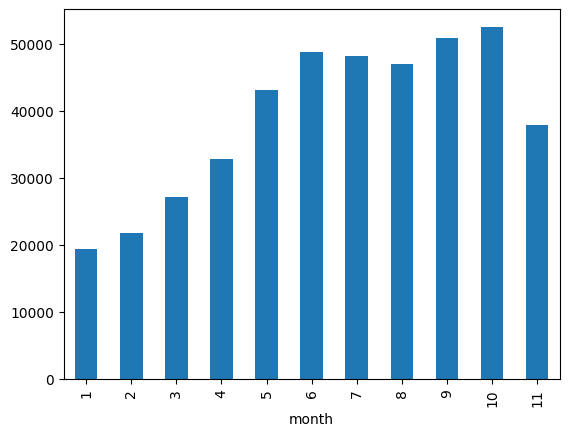

In [123]:
trip_df2.groupby('month').count().iloc[:,0].plot.bar()

<Axes: ylabel='month'>

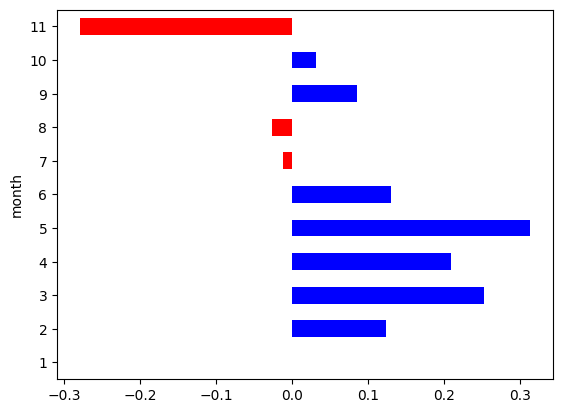

In [124]:
mom = trip_df2.groupby('month').count().iloc[:,1].pct_change()
mom.plot.barh(color=mom.apply(lambda x: 'blue' if x >=0  else 'red').values)

In [ ]:
top_10_stations = trip_df2['start_station_name'].value_counts(ascending=True).iloc[-10::]
top_10_stations.plot.barh()

In [32]:
#Plot Heatmap
filtered_trip_df2 = trip_df2.query('start_station_name in @top_10_stations.index')
gdf = gpd.GeoDataFrame(filtered_trip_df2,
                       geometry=gpd.points_from_xy(filtered_trip_df2.start_lng, filtered_trip_df2.start_lat))
gdf.crs = "EPSG:4326"
m = folium.Map(location=[gdf['start_lat'].mean(), gdf['start_lng'].mean()], zoom_start=11)
heat_data = [[row['start_lat'], row['start_lng']] for index, row in filtered_trip_df2.iterrows()]
HeatMap(heat_data).add_to(m)
m.save('most_popular_start_stations.html')

In [33]:
m

array([<Axes: title={'center': '1'}, xlabel='hour'>,
       <Axes: title={'center': '2'}, xlabel='hour'>,
       <Axes: title={'center': '3'}, xlabel='hour'>,
       <Axes: title={'center': '4'}, xlabel='hour'>,
       <Axes: title={'center': '5'}, xlabel='hour'>,
       <Axes: title={'center': '6'}, xlabel='hour'>,
       <Axes: title={'center': '7'}, xlabel='hour'>], dtype=object)

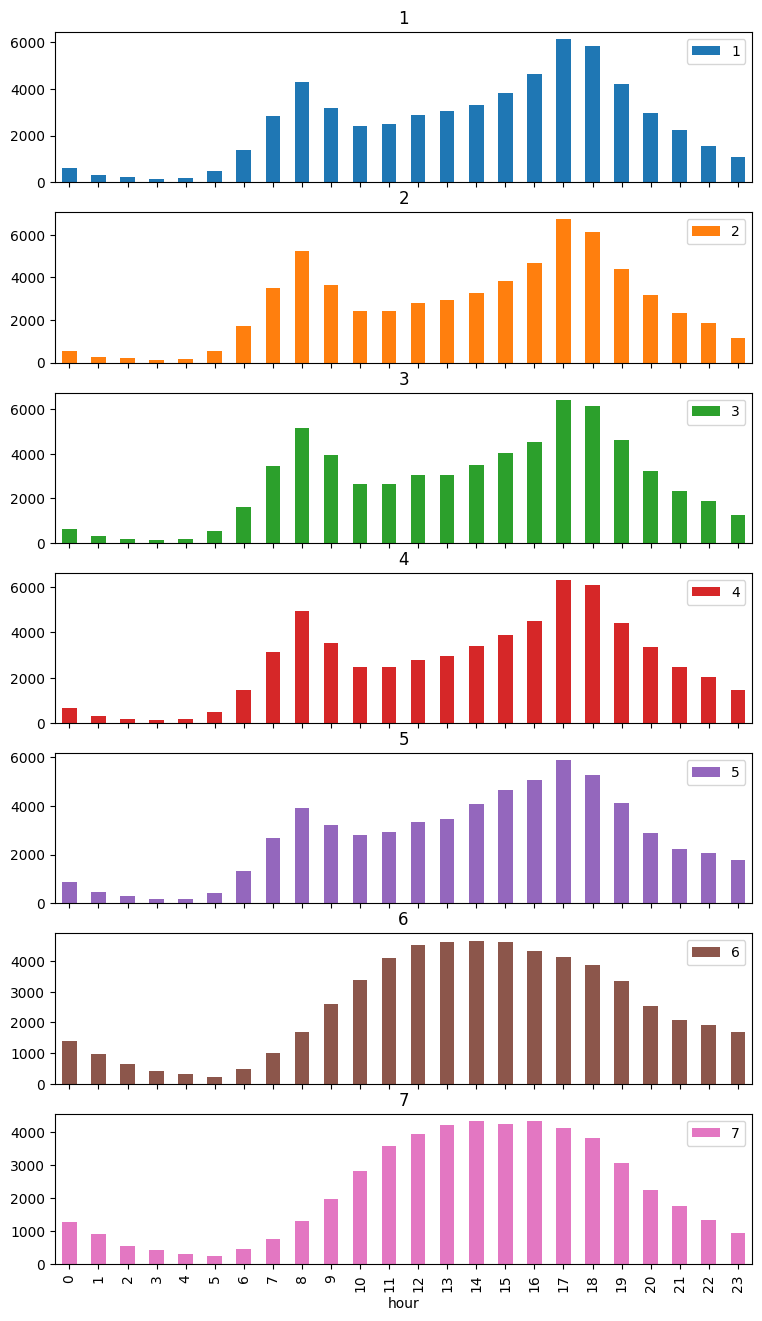

In [34]:
#Peak hours
trip_df2.groupby(['weekday','hour']).count().iloc[:,0].unstack('weekday').plot.bar(subplots=True, figsize=(9,16))

In [35]:
weather_df = pl.scan_csv('data/open-meteo-40.74N74.04W51m(3).csv', try_parse_dates=True, null_values = 'NaN').with_columns(time=pl.col('time').dt.cast_time_unit('ms'))
weather_df.head().collect()

time,temperature_2m_C,relative_humidity_2m_perc,precipitation_mm,weather_code,pressure_msl_hPa,cloud_cover_perc,wind_speed_10m_km_h,is_day
datetime[ms],f64,i64,f64,i64,f64,i64,f64,i64
2012-07-01 00:00:00,29.5,33,0.0,2,1007.4,70,8.6,1
2012-07-01 01:00:00,28.2,34,0.0,1,1008.1,23,10.1,0
2012-07-01 02:00:00,26.7,38,0.0,1,1008.5,21,10.5,0
2012-07-01 03:00:00,25.5,42,0.0,0,1008.8,18,10.1,0
2012-07-01 04:00:00,24.4,46,0.0,0,1008.9,4,9.7,0


# Modelling target location (regression)

In [36]:
def attach_weather_data(input_df: [pl.DataFrame, pl.LazyFrame]) -> [pl.DataFrame, pl.LazyFrame]:
    """
    Augments input_df with weather data loaded from file, matching timestamps based on closest hour. 
    """
    weather_df = pl.scan_csv('data/open-meteo-40.74N74.04W51m(3).csv', try_parse_dates=True, null_values = 'NaN').with_columns(time=pl.col('time').dt.cast_time_unit('ms'))
    return input_df.join(weather_df, left_on='closest_hour', right_on='time').drop('closest_hour')

There are some stations with very few rentals. If subsampling the data these will likely be missing in the training data. Fitting a classification model for the target station will be unsuccesful in that case. Thus we instead treat the problem as regression problem and try to predict the target location, which we can then be geocoded into a target station. Nonetheless there will be some areas underrepresented, this can really only be fixed by inclusion of more data from these areas from other years.

To reformulate this into a geospatial problem, we can predict the coordinates (latitude and longitude) of the end station rather than classifying it as a categorical station ID. By treating the task as a regression problem where the model predicts continuous geographic coordinates (latitude, longitude)

Finally, we can adjust the used a loss function such that the geographic distance between the predicted and true station locations is penalized, e.g. euclidean distance or Haversine distance (great-circle distance).

In [37]:
# scale lat/lon columns
geo_scaler = StandardScaler()
geo_scaler.fit(PER_STATION_LOC_MEAN.select(['lat', 'lng']).collect())

StandardScaler()

# base model on sample data

In [38]:
base_model_data = replace_station_locations_with_mean(trip_df)
base_model_data = attach_weather_data(base_model_data)
base_model_data = base_model_data.collect().to_pandas()
base_model_data = create_cyclic_time_features(base_model_data)
base_model_data, weather_scaler = normalize_weather_features(base_model_data)

In [39]:
X = base_model_data.drop(['lat_end', 'lng_end', 'end_station_name', 'ended_at'], axis=1)
y = geo_scaler.transform(base_model_data[['lat_end', 'lng_end']].set_axis(['lat','lng'], axis=1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=SEED)


dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True, nthread=4)

clf = xgb.train(params={"tree_method": "hist", "multi_strategy": "one_output_per_tree"}, dtrain=dtrain)

In [40]:
distances, preds = evaluate_loc_model(clf, X_test, y_test)

Mean Absolute Error: 0.01 grad
Root Mean Squared Error: 0.13 grad
Mean Euclidean Distance: 39.08 grad
Mean Haversine Distance: 2178.34 m
Maximum Predicted Distance: 4297642.50 m


### Try custom objective function (Haversine Distance)

In [41]:
TRAIN = True


# XGBoost parameters for out-of-core regression
params = {
    'tree_method': 'hist',  # Histogram-based tree construction
    'multi_strategy':'multi_output_tree',
    'num_target': 2,
    'eta': 0.05,
    'max_depth':6,
}

schema = {
        'rideable_type': pl.Categorical,
        'started_at': pl.Datetime,
        'ended_at': pl.Datetime,
        'start_station_name': pl.Categorical,
        'end_station_name': pl.Categorical,
        'member_casual': pl.Categorical,
    }

# init test set
X_test_full = pd.DataFrame()
y_test_full = pd.DataFrame()

num_boost_round = 200
bst = None
# Train the model incrementally on the batches
for i, file in enumerate(glob('data/*tripdata*.csv')):
    print(i, file)
    
    # Load batch data from CSV, could be reconfigured to read directly from AWS S3
    batch_data = pl.scan_csv(file, infer_schema_length=None, schema_overrides=schema, low_memory=True).select(list(schema.keys()))

    # subsample every 20th row (5% of data)
    batch_data.with_row_index().filter(pl.col("index")%10 == 1).drop("index")
    
    # pre-process
    batch_data = replace_station_locations_with_mean(batch_data)
    batch_data = augment_trip_data(batch_data)
    batch_data = attach_weather_data(batch_data)
    batch_data = batch_data.drop_nulls().collect().to_pandas()
    
    
    X = batch_data.drop(['lat_end', 'lng_end', 'end_station_name', 'ended_at'], axis=1)
    y = geo_scaler.transform(batch_data[['lat_end', 'lng_end']].set_axis(['lat','lng'], axis=1))
    y = pd.DataFrame(y, columns= ['lat_end', 'lng_end'])
    X_train, X_test_batch, y_train, y_test_batch = train_test_split(X, y, test_size=0.05, random_state=SEED)

    X_test_full = pd.concat([X_test_full, X_test_batch])
    y_test_full = pd.concat([y_test_full, y_test_batch])

    # batch train
    if TRAIN:
        dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True, nthread=4)
        
        # Fit the model on this batch
        results: Dict[str, Dict[str, List[float]]] = {}
        if not bst:
            bst = xgb.train(
                params,
                dtrain,
                num_boost_round=num_boost_round,
                obj=haversine_loss,
                custom_metric=mean_haversine_distance,
                evals=[(dtrain, 'Train')],
                evals_result = results,
                verbose_eval=25,
            )
        else:
            bst = xgb.train(
                params,
                dtrain,
                num_boost_round=num_boost_round,
                obj=haversine_loss,
                custom_metric=mean_haversine_distance,
                evals=[(dtrain, 'Train')],
                evals_result = results,
                verbose_eval=25,
                xgb_model=bst,
            )
if TRAIN:
    bst.save_model('2024_xgboost_model_lat_lng_hd_m.json')
X_test_full.to_parquet('test_data.parquet')
y_test_full.to_parquet('test_labels.parquet')

0 data/202401-citibike-tripdata.csv


/home/jomic/Dokumente/Bewerbungen 2024/AXA_citibike_challenge/.venv/lib64/python3.13/site-packages/xgboost/core.py:2150: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


[0]	Train-rmse:0.47731	Train-mean_haversine_distance:75051.10156
[25]	Train-rmse:0.17670	Train-mean_haversine_distance:27757.11133
[50]	Train-rmse:0.10958	Train-mean_haversine_distance:17161.74414
[75]	Train-rmse:0.07979	Train-mean_haversine_distance:12442.04785
[100]	Train-rmse:0.06297	Train-mean_haversine_distance:9767.84082
[125]	Train-rmse:0.05219	Train-mean_haversine_distance:8047.68506
[150]	Train-rmse:0.04473	Train-mean_haversine_distance:6850.71289
[175]	Train-rmse:0.03927	Train-mean_haversine_distance:5972.20068
[199]	Train-rmse:0.03528	Train-mean_haversine_distance:5325.84033
1 data/202402-citibike-tripdata.csv


/home/jomic/Dokumente/Bewerbungen 2024/AXA_citibike_challenge/.venv/lib64/python3.13/site-packages/xgboost/core.py:2150: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


[0]	Train-rmse:0.03539	Train-mean_haversine_distance:5330.47705
[25]	Train-rmse:0.03214	Train-mean_haversine_distance:4800.99707
[50]	Train-rmse:0.02955	Train-mean_haversine_distance:4376.82080
[75]	Train-rmse:0.02746	Train-mean_haversine_distance:4030.91235
[100]	Train-rmse:0.02574	Train-mean_haversine_distance:3744.77881
[125]	Train-rmse:0.02431	Train-mean_haversine_distance:3505.27563
[150]	Train-rmse:0.02311	Train-mean_haversine_distance:3302.78223
[175]	Train-rmse:0.02210	Train-mean_haversine_distance:3130.28955
[199]	Train-rmse:0.02128	Train-mean_haversine_distance:2987.88525
2 data/202403-citibike-tripdata.csv


/home/jomic/Dokumente/Bewerbungen 2024/AXA_citibike_challenge/.venv/lib64/python3.13/site-packages/xgboost/core.py:2150: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


[0]	Train-rmse:0.02172	Train-mean_haversine_distance:3015.20410
[25]	Train-rmse:0.02102	Train-mean_haversine_distance:2892.17871
[50]	Train-rmse:0.02043	Train-mean_haversine_distance:2786.22363
[75]	Train-rmse:0.01992	Train-mean_haversine_distance:2694.46338
[100]	Train-rmse:0.01948	Train-mean_haversine_distance:2614.93823
[125]	Train-rmse:0.01910	Train-mean_haversine_distance:2545.74145
[150]	Train-rmse:0.01878	Train-mean_haversine_distance:2485.35864
[175]	Train-rmse:0.01850	Train-mean_haversine_distance:2432.56323
[199]	Train-rmse:0.01826	Train-mean_haversine_distance:2388.02173
3 data/202404-citibike-tripdata.csv


/home/jomic/Dokumente/Bewerbungen 2024/AXA_citibike_challenge/.venv/lib64/python3.13/site-packages/xgboost/core.py:2150: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


[0]	Train-rmse:0.01872	Train-mean_haversine_distance:2433.92383
[25]	Train-rmse:0.01851	Train-mean_haversine_distance:2394.10083
[50]	Train-rmse:0.01833	Train-mean_haversine_distance:2359.44165
[75]	Train-rmse:0.01817	Train-mean_haversine_distance:2329.16846
[100]	Train-rmse:0.01804	Train-mean_haversine_distance:2302.69775
[125]	Train-rmse:0.01792	Train-mean_haversine_distance:2279.47485
[150]	Train-rmse:0.01781	Train-mean_haversine_distance:2259.03833
[175]	Train-rmse:0.01772	Train-mean_haversine_distance:2241.11157
[199]	Train-rmse:0.01765	Train-mean_haversine_distance:2225.92529
4 data/202405-citibike-tripdata_1.csv


/home/jomic/Dokumente/Bewerbungen 2024/AXA_citibike_challenge/.venv/lib64/python3.13/site-packages/xgboost/core.py:2150: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


[0]	Train-rmse:0.01851	Train-mean_haversine_distance:2315.20044
[25]	Train-rmse:0.01843	Train-mean_haversine_distance:2301.14429
[50]	Train-rmse:0.01837	Train-mean_haversine_distance:2289.09790
[75]	Train-rmse:0.01831	Train-mean_haversine_distance:2278.73486
[100]	Train-rmse:0.01826	Train-mean_haversine_distance:2269.76392
[125]	Train-rmse:0.01822	Train-mean_haversine_distance:2261.97119
[150]	Train-rmse:0.01818	Train-mean_haversine_distance:2255.21533
[175]	Train-rmse:0.01815	Train-mean_haversine_distance:2249.35522
[199]	Train-rmse:0.01812	Train-mean_haversine_distance:2244.42139
5 data/202405-citibike-tripdata_2.csv


/home/jomic/Dokumente/Bewerbungen 2024/AXA_citibike_challenge/.venv/lib64/python3.13/site-packages/xgboost/core.py:2150: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


[0]	Train-rmse:0.01760	Train-mean_haversine_distance:2142.34277
[25]	Train-rmse:0.01757	Train-mean_haversine_distance:2136.81934
[50]	Train-rmse:0.01753	Train-mean_haversine_distance:2132.27417
[75]	Train-rmse:0.01751	Train-mean_haversine_distance:2128.52808
[100]	Train-rmse:0.01748	Train-mean_haversine_distance:2125.29590
[125]	Train-rmse:0.01746	Train-mean_haversine_distance:2122.43921
[150]	Train-rmse:0.01744	Train-mean_haversine_distance:2120.10156
[175]	Train-rmse:0.01743	Train-mean_haversine_distance:2118.04224
[199]	Train-rmse:0.01742	Train-mean_haversine_distance:2116.35352
6 data/202405-citibike-tripdata_3.csv


/home/jomic/Dokumente/Bewerbungen 2024/AXA_citibike_challenge/.venv/lib64/python3.13/site-packages/xgboost/core.py:2150: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


[0]	Train-rmse:0.08611	Train-mean_haversine_distance:2214.38477
[25]	Train-rmse:0.74038	Train-mean_haversine_distance:2204.39307
[50]	Train-rmse:0.74066	Train-mean_haversine_distance:2201.79981
[75]	Train-rmse:0.74070	Train-mean_haversine_distance:2199.18359
[100]	Train-rmse:0.74072	Train-mean_haversine_distance:2196.92310
[125]	Train-rmse:0.74073	Train-mean_haversine_distance:2195.01416
[150]	Train-rmse:0.74077	Train-mean_haversine_distance:2193.28564
[175]	Train-rmse:0.74084	Train-mean_haversine_distance:2191.75537
[199]	Train-rmse:0.74086	Train-mean_haversine_distance:2190.43628
7 data/202405-citibike-tripdata_4.csv


/home/jomic/Dokumente/Bewerbungen 2024/AXA_citibike_challenge/.venv/lib64/python3.13/site-packages/xgboost/core.py:2150: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


[0]	Train-rmse:0.08573	Train-mean_haversine_distance:2179.42261
[25]	Train-rmse:0.73825	Train-mean_haversine_distance:2168.75366
[50]	Train-rmse:0.73846	Train-mean_haversine_distance:2165.54834
[75]	Train-rmse:0.73846	Train-mean_haversine_distance:2162.78149
[100]	Train-rmse:0.73846	Train-mean_haversine_distance:2160.12964
[125]	Train-rmse:0.73846	Train-mean_haversine_distance:2157.63843
[150]	Train-rmse:0.73847	Train-mean_haversine_distance:2155.44336
[175]	Train-rmse:0.73847	Train-mean_haversine_distance:2153.42871
[199]	Train-rmse:0.73847	Train-mean_haversine_distance:2151.68506
8 data/202405-citibike-tripdata_5.csv


/home/jomic/Dokumente/Bewerbungen 2024/AXA_citibike_challenge/.venv/lib64/python3.13/site-packages/xgboost/core.py:2150: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


[0]	Train-rmse:0.01761	Train-mean_haversine_distance:2145.73877
[25]	Train-rmse:0.01750	Train-mean_haversine_distance:2142.21216
[50]	Train-rmse:0.01745	Train-mean_haversine_distance:2139.88965
[75]	Train-rmse:0.01743	Train-mean_haversine_distance:2138.05884
[100]	Train-rmse:0.01741	Train-mean_haversine_distance:2136.50269
[125]	Train-rmse:0.01740	Train-mean_haversine_distance:2135.12231
[150]	Train-rmse:0.01738	Train-mean_haversine_distance:2133.78320
[175]	Train-rmse:0.01737	Train-mean_haversine_distance:2132.49805
[199]	Train-rmse:0.01736	Train-mean_haversine_distance:2131.38013
9 data/202406-citibike-tripdata_5.csv


/home/jomic/Dokumente/Bewerbungen 2024/AXA_citibike_challenge/.venv/lib64/python3.13/site-packages/xgboost/core.py:2150: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


[0]	Train-rmse:0.01833	Train-mean_haversine_distance:2260.05493
[25]	Train-rmse:0.01831	Train-mean_haversine_distance:2257.72437
[50]	Train-rmse:0.01830	Train-mean_haversine_distance:2255.72070
[75]	Train-rmse:0.01828	Train-mean_haversine_distance:2253.85303
[100]	Train-rmse:0.01827	Train-mean_haversine_distance:2252.08691
[125]	Train-rmse:0.01826	Train-mean_haversine_distance:2250.54785
[150]	Train-rmse:0.01825	Train-mean_haversine_distance:2249.14380
[175]	Train-rmse:0.01825	Train-mean_haversine_distance:2247.83618
[199]	Train-rmse:0.01824	Train-mean_haversine_distance:2246.71191
10 data/202406-citibike-tripdata_4.csv


/home/jomic/Dokumente/Bewerbungen 2024/AXA_citibike_challenge/.venv/lib64/python3.13/site-packages/xgboost/core.py:2150: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


[0]	Train-rmse:0.66160	Train-mean_haversine_distance:2262.80200
[25]	Train-rmse:0.73928	Train-mean_haversine_distance:2248.63721
[50]	Train-rmse:0.73927	Train-mean_haversine_distance:2244.91431
[75]	Train-rmse:0.73926	Train-mean_haversine_distance:2241.51831
[100]	Train-rmse:0.73925	Train-mean_haversine_distance:2238.37866
[125]	Train-rmse:0.73924	Train-mean_haversine_distance:2235.46948
[150]	Train-rmse:0.73924	Train-mean_haversine_distance:2232.85547
[175]	Train-rmse:0.73924	Train-mean_haversine_distance:2230.46533
[199]	Train-rmse:0.73923	Train-mean_haversine_distance:2228.31226
11 data/202406-citibike-tripdata_1.csv


/home/jomic/Dokumente/Bewerbungen 2024/AXA_citibike_challenge/.venv/lib64/python3.13/site-packages/xgboost/core.py:2150: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


[0]	Train-rmse:1.67699	Train-mean_haversine_distance:2357.34863
[25]	Train-rmse:14.10548	Train-mean_haversine_distance:4912.36670
[50]	Train-rmse:26.05485	Train-mean_haversine_distance:17684.05078
[75]	Train-rmse:50.99417	Train-mean_haversine_distance:23632.88086
[100]	Train-rmse:53.21482	Train-mean_haversine_distance:27334.03516
[125]	Train-rmse:58.86193	Train-mean_haversine_distance:26925.93750
[150]	Train-rmse:63.18571	Train-mean_haversine_distance:29284.98633
[175]	Train-rmse:65.77751	Train-mean_haversine_distance:27472.94141
[199]	Train-rmse:67.64500	Train-mean_haversine_distance:26802.33594
12 data/202406-citibike-tripdata_3.csv


/home/jomic/Dokumente/Bewerbungen 2024/AXA_citibike_challenge/.venv/lib64/python3.13/site-packages/xgboost/core.py:2150: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


[0]	Train-rmse:116.25671	Train-mean_haversine_distance:52786.37500
[25]	Train-rmse:117.42633	Train-mean_haversine_distance:88413.15625
[50]	Train-rmse:124.34945	Train-mean_haversine_distance:114343.03906
[75]	Train-rmse:132.28241	Train-mean_haversine_distance:128716.65625
[100]	Train-rmse:138.62068	Train-mean_haversine_distance:142710.32812
[125]	Train-rmse:155.86127	Train-mean_haversine_distance:151924.67188
[150]	Train-rmse:182.68691	Train-mean_haversine_distance:200184.98438
[175]	Train-rmse:240.98575	Train-mean_haversine_distance:177375.15625
[199]	Train-rmse:242.18818	Train-mean_haversine_distance:185369.75000
13 data/202406-citibike-tripdata_2.csv


/home/jomic/Dokumente/Bewerbungen 2024/AXA_citibike_challenge/.venv/lib64/python3.13/site-packages/xgboost/core.py:2150: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


[0]	Train-rmse:192.62595	Train-mean_haversine_distance:143940.56250
[25]	Train-rmse:229.32869	Train-mean_haversine_distance:144340.14062
[50]	Train-rmse:241.05077	Train-mean_haversine_distance:145805.06250
[75]	Train-rmse:259.05353	Train-mean_haversine_distance:185443.25000
[100]	Train-rmse:291.57454	Train-mean_haversine_distance:182330.82812
[125]	Train-rmse:326.46505	Train-mean_haversine_distance:300111.50000
[150]	Train-rmse:364.26340	Train-mean_haversine_distance:358409.53125
[175]	Train-rmse:415.00718	Train-mean_haversine_distance:337916.00000
[199]	Train-rmse:451.99530	Train-mean_haversine_distance:397510.62500
14 data/202407-citibike-tripdata_1.csv


/home/jomic/Dokumente/Bewerbungen 2024/AXA_citibike_challenge/.venv/lib64/python3.13/site-packages/xgboost/core.py:2150: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


[0]	Train-rmse:692.08897	Train-mean_haversine_distance:973763.50000
[25]	Train-rmse:769.38958	Train-mean_haversine_distance:1397875.50000
[50]	Train-rmse:796.94048	Train-mean_haversine_distance:1430886.37500
[75]	Train-rmse:927.64425	Train-mean_haversine_distance:2418584.50000
[100]	Train-rmse:995.78095	Train-mean_haversine_distance:2764679.00000
[125]	Train-rmse:1047.95965	Train-mean_haversine_distance:3747605.50000
[150]	Train-rmse:1148.97047	Train-mean_haversine_distance:6807118.50000
[175]	Train-rmse:1447.12236	Train-mean_haversine_distance:9851649.00000
[199]	Train-rmse:1585.19876	Train-mean_haversine_distance:10136995.00000
15 data/202407-citibike-tripdata_2.csv


/home/jomic/Dokumente/Bewerbungen 2024/AXA_citibike_challenge/.venv/lib64/python3.13/site-packages/xgboost/core.py:2150: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


[0]	Train-rmse:1490.34523	Train-mean_haversine_distance:10002422.00000
[25]	Train-rmse:1598.11363	Train-mean_haversine_distance:9829033.00000
[50]	Train-rmse:1713.64368	Train-mean_haversine_distance:9795942.00000
[75]	Train-rmse:1802.85267	Train-mean_haversine_distance:9834318.00000
[100]	Train-rmse:1880.48597	Train-mean_haversine_distance:9772865.00000
[125]	Train-rmse:1947.55086	Train-mean_haversine_distance:9852745.00000
[150]	Train-rmse:2004.71013	Train-mean_haversine_distance:10037495.00000
[175]	Train-rmse:2056.87406	Train-mean_haversine_distance:9961324.00000
[199]	Train-rmse:2092.59343	Train-mean_haversine_distance:9759352.00000
16 data/202407-citibike-tripdata_3.csv


/home/jomic/Dokumente/Bewerbungen 2024/AXA_citibike_challenge/.venv/lib64/python3.13/site-packages/xgboost/core.py:2150: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


[0]	Train-rmse:2141.59044	Train-mean_haversine_distance:10028968.00000
[25]	Train-rmse:2207.84537	Train-mean_haversine_distance:9880579.00000
[50]	Train-rmse:2254.14137	Train-mean_haversine_distance:9777430.00000
[75]	Train-rmse:2301.30716	Train-mean_haversine_distance:9855608.00000
[100]	Train-rmse:2342.62097	Train-mean_haversine_distance:10025091.00000
[125]	Train-rmse:2365.10520	Train-mean_haversine_distance:9903937.00000
[150]	Train-rmse:2404.79012	Train-mean_haversine_distance:9886124.00000
[175]	Train-rmse:2446.16670	Train-mean_haversine_distance:9917680.00000
[199]	Train-rmse:2457.79337	Train-mean_haversine_distance:9595114.00000
17 data/202407-citibike-tripdata_4.csv


/home/jomic/Dokumente/Bewerbungen 2024/AXA_citibike_challenge/.venv/lib64/python3.13/site-packages/xgboost/core.py:2150: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


[0]	Train-rmse:2436.43789	Train-mean_haversine_distance:9971598.00000
[25]	Train-rmse:2492.90249	Train-mean_haversine_distance:9932731.00000
[50]	Train-rmse:2529.82303	Train-mean_haversine_distance:9895848.00000
[75]	Train-rmse:2567.69868	Train-mean_haversine_distance:9698593.00000
[100]	Train-rmse:2630.36642	Train-mean_haversine_distance:9836398.00000
[125]	Train-rmse:2661.47138	Train-mean_haversine_distance:9746306.00000
[150]	Train-rmse:2713.93032	Train-mean_haversine_distance:9935877.00000


/home/jomic/Dokumente/Bewerbungen 2024/AXA_citibike_challenge/citibike_utils/__init__.py:72: RuntimeWarning: invalid value encountered in sqrt
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
/home/jomic/Dokumente/Bewerbungen 2024/AXA_citibike_challenge/citibike_utils/__init__.py:101: RuntimeWarning: invalid value encountered in sqrt
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))


[175]	Train-rmse:2754.64626	Train-mean_haversine_distance:nan
[199]	Train-rmse:2767.84807	Train-mean_haversine_distance:nan
18 data/202407-citibike-tripdata_5.csv


/home/jomic/Dokumente/Bewerbungen 2024/AXA_citibike_challenge/.venv/lib64/python3.13/site-packages/xgboost/core.py:2150: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


[0]	Train-rmse:2752.64676	Train-mean_haversine_distance:10091623.00000
[25]	Train-rmse:2800.64342	Train-mean_haversine_distance:10010976.00000
[50]	Train-rmse:2815.66503	Train-mean_haversine_distance:9919111.00000
[75]	Train-rmse:2858.86491	Train-mean_haversine_distance:9850141.00000
[100]	Train-rmse:2893.13783	Train-mean_haversine_distance:9852960.00000
[125]	Train-rmse:2942.82852	Train-mean_haversine_distance:9853439.00000
[150]	Train-rmse:2973.98561	Train-mean_haversine_distance:9863809.00000
[175]	Train-rmse:3012.16844	Train-mean_haversine_distance:9855139.00000
[199]	Train-rmse:3065.91161	Train-mean_haversine_distance:9874435.00000
19 data/202408-citibike-tripdata_3.csv


/home/jomic/Dokumente/Bewerbungen 2024/AXA_citibike_challenge/.venv/lib64/python3.13/site-packages/xgboost/core.py:2150: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


[0]	Train-rmse:2845.97089	Train-mean_haversine_distance:9997823.00000
[25]	Train-rmse:2875.88289	Train-mean_haversine_distance:9801900.00000
[50]	Train-rmse:2914.46074	Train-mean_haversine_distance:9850905.00000
[75]	Train-rmse:2937.73240	Train-mean_haversine_distance:9871976.00000
[100]	Train-rmse:2956.62550	Train-mean_haversine_distance:9726463.00000
[125]	Train-rmse:2972.04156	Train-mean_haversine_distance:9839217.00000
[150]	Train-rmse:2996.95507	Train-mean_haversine_distance:9947906.00000
[175]	Train-rmse:3024.47154	Train-mean_haversine_distance:9866597.00000
[199]	Train-rmse:3066.03867	Train-mean_haversine_distance:9921901.00000
20 data/202408-citibike-tripdata_2.csv


/home/jomic/Dokumente/Bewerbungen 2024/AXA_citibike_challenge/.venv/lib64/python3.13/site-packages/xgboost/core.py:2150: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


[0]	Train-rmse:3179.21020	Train-mean_haversine_distance:9907610.00000
[25]	Train-rmse:3199.74739	Train-mean_haversine_distance:9760519.00000
[50]	Train-rmse:3229.17507	Train-mean_haversine_distance:9797235.00000
[75]	Train-rmse:3252.85468	Train-mean_haversine_distance:9770405.00000
[100]	Train-rmse:3262.27221	Train-mean_haversine_distance:9798825.00000
[125]	Train-rmse:3293.90489	Train-mean_haversine_distance:9809799.00000
[150]	Train-rmse:3288.68758	Train-mean_haversine_distance:9803498.00000
[175]	Train-rmse:3313.69511	Train-mean_haversine_distance:9687769.00000
[199]	Train-rmse:3328.90881	Train-mean_haversine_distance:9817234.00000
21 data/202408-citibike-tripdata_1.csv


/home/jomic/Dokumente/Bewerbungen 2024/AXA_citibike_challenge/.venv/lib64/python3.13/site-packages/xgboost/core.py:2150: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


[0]	Train-rmse:3319.89324	Train-mean_haversine_distance:10080808.00000
[25]	Train-rmse:3333.44951	Train-mean_haversine_distance:9701863.00000
[50]	Train-rmse:3343.46640	Train-mean_haversine_distance:9766562.00000
[75]	Train-rmse:3350.57115	Train-mean_haversine_distance:9824691.00000
[100]	Train-rmse:3350.70047	Train-mean_haversine_distance:9747329.00000
[125]	Train-rmse:3351.35670	Train-mean_haversine_distance:9725127.00000
[150]	Train-rmse:3358.19106	Train-mean_haversine_distance:9797990.00000
[175]	Train-rmse:3357.24931	Train-mean_haversine_distance:9782703.00000
[199]	Train-rmse:3356.85646	Train-mean_haversine_distance:9734256.00000
22 data/202408-citibike-tripdata_5.csv


/home/jomic/Dokumente/Bewerbungen 2024/AXA_citibike_challenge/.venv/lib64/python3.13/site-packages/xgboost/core.py:2150: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


[0]	Train-rmse:3475.29655	Train-mean_haversine_distance:10014845.00000
[25]	Train-rmse:3482.26905	Train-mean_haversine_distance:9843118.00000
[50]	Train-rmse:3486.37639	Train-mean_haversine_distance:9796364.00000
[75]	Train-rmse:3488.45060	Train-mean_haversine_distance:9798839.00000
[100]	Train-rmse:3489.97805	Train-mean_haversine_distance:9748815.00000
[125]	Train-rmse:3491.40502	Train-mean_haversine_distance:9754615.00000
[150]	Train-rmse:3492.45446	Train-mean_haversine_distance:9732757.00000
[175]	Train-rmse:3493.63602	Train-mean_haversine_distance:9744261.00000
[199]	Train-rmse:3494.05027	Train-mean_haversine_distance:9793384.00000
23 data/202408-citibike-tripdata_4.csv


/home/jomic/Dokumente/Bewerbungen 2024/AXA_citibike_challenge/.venv/lib64/python3.13/site-packages/xgboost/core.py:2150: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


[0]	Train-rmse:3464.62733	Train-mean_haversine_distance:10025999.00000
[25]	Train-rmse:3464.41531	Train-mean_haversine_distance:9933874.00000
[50]	Train-rmse:3464.86260	Train-mean_haversine_distance:9887661.00000
[75]	Train-rmse:3466.05610	Train-mean_haversine_distance:9842696.00000
[100]	Train-rmse:3466.20542	Train-mean_haversine_distance:9830451.00000
[125]	Train-rmse:3466.60161	Train-mean_haversine_distance:9822594.00000
[150]	Train-rmse:3466.33447	Train-mean_haversine_distance:9809549.00000
[175]	Train-rmse:3467.21504	Train-mean_haversine_distance:9805952.00000
[199]	Train-rmse:3467.02968	Train-mean_haversine_distance:9792302.00000
24 data/202409-citibike-tripdata_1.csv


/home/jomic/Dokumente/Bewerbungen 2024/AXA_citibike_challenge/.venv/lib64/python3.13/site-packages/xgboost/core.py:2150: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


[0]	Train-rmse:3596.63961	Train-mean_haversine_distance:10009068.00000
[25]	Train-rmse:3596.10773	Train-mean_haversine_distance:9978148.00000
[50]	Train-rmse:3595.96687	Train-mean_haversine_distance:9957874.00000
[75]	Train-rmse:3595.90532	Train-mean_haversine_distance:9950496.00000
[100]	Train-rmse:3596.12294	Train-mean_haversine_distance:9943848.00000
[125]	Train-rmse:3595.81295	Train-mean_haversine_distance:9931101.00000
[150]	Train-rmse:3596.17957	Train-mean_haversine_distance:9925159.00000
[175]	Train-rmse:3596.32364	Train-mean_haversine_distance:9922420.00000


/home/jomic/Dokumente/Bewerbungen 2024/AXA_citibike_challenge/citibike_utils/__init__.py:72: RuntimeWarning: invalid value encountered in sqrt
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
/home/jomic/Dokumente/Bewerbungen 2024/AXA_citibike_challenge/citibike_utils/__init__.py:101: RuntimeWarning: invalid value encountered in sqrt
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))


[199]	Train-rmse:3596.36610	Train-mean_haversine_distance:nan
25 data/202409-citibike-tripdata_2.csv


/home/jomic/Dokumente/Bewerbungen 2024/AXA_citibike_challenge/.venv/lib64/python3.13/site-packages/xgboost/core.py:2150: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


[0]	Train-rmse:3296.65801	Train-mean_haversine_distance:10016827.00000
[25]	Train-rmse:3298.21124	Train-mean_haversine_distance:10003609.00000
[50]	Train-rmse:3299.15544	Train-mean_haversine_distance:9992519.00000
[75]	Train-rmse:3299.25939	Train-mean_haversine_distance:9986713.00000
[100]	Train-rmse:3299.42395	Train-mean_haversine_distance:9976258.00000
[125]	Train-rmse:3299.62745	Train-mean_haversine_distance:9975234.00000
[150]	Train-rmse:3299.77923	Train-mean_haversine_distance:9973522.00000
[175]	Train-rmse:3299.84712	Train-mean_haversine_distance:9972966.00000
[199]	Train-rmse:3300.06561	Train-mean_haversine_distance:9969358.00000
26 data/202409-citibike-tripdata_3.csv


/home/jomic/Dokumente/Bewerbungen 2024/AXA_citibike_challenge/.venv/lib64/python3.13/site-packages/xgboost/core.py:2150: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


[0]	Train-rmse:3454.41349	Train-mean_haversine_distance:10017854.00000
[25]	Train-rmse:3454.46476	Train-mean_haversine_distance:10006591.00000
[50]	Train-rmse:3454.45346	Train-mean_haversine_distance:10000253.00000


/home/jomic/Dokumente/Bewerbungen 2024/AXA_citibike_challenge/citibike_utils/__init__.py:72: RuntimeWarning: invalid value encountered in sqrt
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
/home/jomic/Dokumente/Bewerbungen 2024/AXA_citibike_challenge/citibike_utils/__init__.py:101: RuntimeWarning: invalid value encountered in sqrt
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))


[75]	Train-rmse:3454.43468	Train-mean_haversine_distance:nan
[100]	Train-rmse:3454.62091	Train-mean_haversine_distance:nan
[125]	Train-rmse:3454.59622	Train-mean_haversine_distance:nan
[150]	Train-rmse:3454.65084	Train-mean_haversine_distance:nan
[175]	Train-rmse:3454.98381	Train-mean_haversine_distance:nan
[199]	Train-rmse:3454.97719	Train-mean_haversine_distance:nan
27 data/202409-citibike-tripdata_4.csv


/home/jomic/Dokumente/Bewerbungen 2024/AXA_citibike_challenge/.venv/lib64/python3.13/site-packages/xgboost/core.py:2150: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


[0]	Train-rmse:3351.27544	Train-mean_haversine_distance:10030583.00000
[25]	Train-rmse:3353.59497	Train-mean_haversine_distance:10013980.00000
[50]	Train-rmse:3354.13673	Train-mean_haversine_distance:10001730.00000
[75]	Train-rmse:3353.87071	Train-mean_haversine_distance:9992872.00000
[100]	Train-rmse:3354.09687	Train-mean_haversine_distance:9988298.00000
[125]	Train-rmse:3354.11495	Train-mean_haversine_distance:9986438.00000
[150]	Train-rmse:3354.06435	Train-mean_haversine_distance:9984363.00000


/home/jomic/Dokumente/Bewerbungen 2024/AXA_citibike_challenge/citibike_utils/__init__.py:72: RuntimeWarning: invalid value encountered in sqrt
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
/home/jomic/Dokumente/Bewerbungen 2024/AXA_citibike_challenge/citibike_utils/__init__.py:101: RuntimeWarning: invalid value encountered in sqrt
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))


[175]	Train-rmse:3354.15666	Train-mean_haversine_distance:nan
[199]	Train-rmse:3354.26948	Train-mean_haversine_distance:nan
28 data/202409-citibike-tripdata_5.csv


/home/jomic/Dokumente/Bewerbungen 2024/AXA_citibike_challenge/.venv/lib64/python3.13/site-packages/xgboost/core.py:2150: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


[0]	Train-rmse:3542.82648	Train-mean_haversine_distance:10026335.00000
[25]	Train-rmse:3543.28229	Train-mean_haversine_distance:9999812.00000
[50]	Train-rmse:3543.39218	Train-mean_haversine_distance:9977999.00000
[75]	Train-rmse:3543.45936	Train-mean_haversine_distance:9966300.00000
[100]	Train-rmse:3543.54667	Train-mean_haversine_distance:9964139.00000
[125]	Train-rmse:3543.66196	Train-mean_haversine_distance:9961770.00000
[150]	Train-rmse:3543.75140	Train-mean_haversine_distance:9960568.00000
[175]	Train-rmse:3543.85527	Train-mean_haversine_distance:9959736.00000
[199]	Train-rmse:3543.80292	Train-mean_haversine_distance:9959272.00000
29 data/202410-citibike-tripdata_6.csv


/home/jomic/Dokumente/Bewerbungen 2024/AXA_citibike_challenge/.venv/lib64/python3.13/site-packages/xgboost/core.py:2150: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


[0]	Train-rmse:3456.42463	Train-mean_haversine_distance:10010456.00000
[25]	Train-rmse:3457.00366	Train-mean_haversine_distance:9987525.00000
[50]	Train-rmse:3456.77742	Train-mean_haversine_distance:9974590.00000
[75]	Train-rmse:3457.02688	Train-mean_haversine_distance:9966787.00000
[100]	Train-rmse:3457.20342	Train-mean_haversine_distance:9964621.00000
[125]	Train-rmse:3457.46994	Train-mean_haversine_distance:9962945.00000
[150]	Train-rmse:3458.02593	Train-mean_haversine_distance:9961884.00000
[175]	Train-rmse:3457.97063	Train-mean_haversine_distance:9954990.00000
[199]	Train-rmse:3458.76498	Train-mean_haversine_distance:9959468.00000
30 data/202410-citibike-tripdata_4.csv


/home/jomic/Dokumente/Bewerbungen 2024/AXA_citibike_challenge/.venv/lib64/python3.13/site-packages/xgboost/core.py:2150: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


[0]	Train-rmse:3385.06695	Train-mean_haversine_distance:10019753.00000
[25]	Train-rmse:3385.83599	Train-mean_haversine_distance:10018424.00000
[50]	Train-rmse:3385.81618	Train-mean_haversine_distance:10016933.00000
[75]	Train-rmse:3385.81743	Train-mean_haversine_distance:10016751.00000
[100]	Train-rmse:3385.82327	Train-mean_haversine_distance:10016123.00000
[125]	Train-rmse:3385.94723	Train-mean_haversine_distance:10015462.00000
[150]	Train-rmse:3385.97944	Train-mean_haversine_distance:10014991.00000
[175]	Train-rmse:3386.06292	Train-mean_haversine_distance:10014535.00000


/home/jomic/Dokumente/Bewerbungen 2024/AXA_citibike_challenge/citibike_utils/__init__.py:72: RuntimeWarning: invalid value encountered in sqrt
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
/home/jomic/Dokumente/Bewerbungen 2024/AXA_citibike_challenge/citibike_utils/__init__.py:101: RuntimeWarning: invalid value encountered in sqrt
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))


[199]	Train-rmse:3386.03342	Train-mean_haversine_distance:nan
31 data/202410-citibike-tripdata_5.csv


/home/jomic/Dokumente/Bewerbungen 2024/AXA_citibike_challenge/.venv/lib64/python3.13/site-packages/xgboost/core.py:2150: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


[0]	Train-rmse:3478.38138	Train-mean_haversine_distance:10020795.00000
[25]	Train-rmse:3477.98697	Train-mean_haversine_distance:10017825.00000
[50]	Train-rmse:3477.99062	Train-mean_haversine_distance:10013456.00000
[75]	Train-rmse:3478.01990	Train-mean_haversine_distance:10011441.00000
[100]	Train-rmse:3477.93489	Train-mean_haversine_distance:10010992.00000
[125]	Train-rmse:3477.95239	Train-mean_haversine_distance:10008671.00000
[150]	Train-rmse:3477.92924	Train-mean_haversine_distance:10006106.00000
[175]	Train-rmse:3478.09194	Train-mean_haversine_distance:10005269.00000
[199]	Train-rmse:3478.35282	Train-mean_haversine_distance:10005508.00000
32 data/202410-citibike-tripdata_1.csv


/home/jomic/Dokumente/Bewerbungen 2024/AXA_citibike_challenge/.venv/lib64/python3.13/site-packages/xgboost/core.py:2150: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


[0]	Train-rmse:3562.39169	Train-mean_haversine_distance:10018961.00000
[25]	Train-rmse:3562.19138	Train-mean_haversine_distance:10014084.00000
[50]	Train-rmse:3562.18362	Train-mean_haversine_distance:10012296.00000
[75]	Train-rmse:3562.19571	Train-mean_haversine_distance:10008393.00000
[100]	Train-rmse:3562.19990	Train-mean_haversine_distance:10005278.00000
[125]	Train-rmse:3562.15539	Train-mean_haversine_distance:10004670.00000
[150]	Train-rmse:3562.31014	Train-mean_haversine_distance:10005577.00000
[175]	Train-rmse:3562.29607	Train-mean_haversine_distance:10003734.00000
[199]	Train-rmse:3562.31813	Train-mean_haversine_distance:10003571.00000
33 data/202410-citibike-tripdata_2.csv


/home/jomic/Dokumente/Bewerbungen 2024/AXA_citibike_challenge/.venv/lib64/python3.13/site-packages/xgboost/core.py:2150: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


[0]	Train-rmse:3411.41054	Train-mean_haversine_distance:10017849.00000
[25]	Train-rmse:3412.07368	Train-mean_haversine_distance:10007132.00000
[50]	Train-rmse:3412.20400	Train-mean_haversine_distance:10003731.00000
[75]	Train-rmse:3411.91637	Train-mean_haversine_distance:10000326.00000
[100]	Train-rmse:3412.13871	Train-mean_haversine_distance:9997653.00000
[125]	Train-rmse:3412.20686	Train-mean_haversine_distance:9996901.00000
[150]	Train-rmse:3412.19698	Train-mean_haversine_distance:9996183.00000
[175]	Train-rmse:3412.14889	Train-mean_haversine_distance:9996213.00000
[199]	Train-rmse:3412.27068	Train-mean_haversine_distance:9996411.00000
34 data/202410-citibike-tripdata_3.csv


/home/jomic/Dokumente/Bewerbungen 2024/AXA_citibike_challenge/.venv/lib64/python3.13/site-packages/xgboost/core.py:2150: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


[0]	Train-rmse:3414.20204	Train-mean_haversine_distance:10017619.00000
[25]	Train-rmse:3413.90577	Train-mean_haversine_distance:10014546.00000
[50]	Train-rmse:3413.69465	Train-mean_haversine_distance:10009950.00000
[75]	Train-rmse:3413.80206	Train-mean_haversine_distance:10007805.00000
[100]	Train-rmse:3413.85380	Train-mean_haversine_distance:10004231.00000
[125]	Train-rmse:3413.86713	Train-mean_haversine_distance:10002495.00000
[150]	Train-rmse:3414.02490	Train-mean_haversine_distance:10000790.00000
[175]	Train-rmse:3414.11310	Train-mean_haversine_distance:10000501.00000
[199]	Train-rmse:3414.26572	Train-mean_haversine_distance:9999522.00000
35 data/202411-citibike-tripdata_3.csv


/home/jomic/Dokumente/Bewerbungen 2024/AXA_citibike_challenge/.venv/lib64/python3.13/site-packages/xgboost/core.py:2150: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


[0]	Train-rmse:3378.34542	Train-mean_haversine_distance:10013489.00000
[25]	Train-rmse:3377.62460	Train-mean_haversine_distance:10013694.00000
[50]	Train-rmse:3377.65307	Train-mean_haversine_distance:10014581.00000
[75]	Train-rmse:3377.80938	Train-mean_haversine_distance:10012462.00000
[100]	Train-rmse:3377.85877	Train-mean_haversine_distance:10010937.00000
[125]	Train-rmse:3378.02183	Train-mean_haversine_distance:10010359.00000
[150]	Train-rmse:3378.06120	Train-mean_haversine_distance:10010810.00000
[175]	Train-rmse:3378.12797	Train-mean_haversine_distance:10010683.00000
[199]	Train-rmse:3378.24290	Train-mean_haversine_distance:10010033.00000
36 data/202411-citibike-tripdata_2.csv


/home/jomic/Dokumente/Bewerbungen 2024/AXA_citibike_challenge/.venv/lib64/python3.13/site-packages/xgboost/core.py:2150: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


[0]	Train-rmse:3476.94386	Train-mean_haversine_distance:10022994.00000
[25]	Train-rmse:3477.43132	Train-mean_haversine_distance:10013999.00000
[50]	Train-rmse:3477.31195	Train-mean_haversine_distance:10012590.00000
[75]	Train-rmse:3477.34086	Train-mean_haversine_distance:10011295.00000
[100]	Train-rmse:3477.57061	Train-mean_haversine_distance:10010983.00000
[125]	Train-rmse:3477.74585	Train-mean_haversine_distance:10010437.00000
[150]	Train-rmse:3477.64763	Train-mean_haversine_distance:10010353.00000
[175]	Train-rmse:3477.71912	Train-mean_haversine_distance:10009985.00000
[199]	Train-rmse:3477.68988	Train-mean_haversine_distance:10009273.00000
37 data/202411-citibike-tripdata_1.csv


/home/jomic/Dokumente/Bewerbungen 2024/AXA_citibike_challenge/.venv/lib64/python3.13/site-packages/xgboost/core.py:2150: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


[0]	Train-rmse:3374.24758	Train-mean_haversine_distance:10020103.00000
[25]	Train-rmse:3374.01367	Train-mean_haversine_distance:10009671.00000
[50]	Train-rmse:3374.17405	Train-mean_haversine_distance:10008355.00000
[75]	Train-rmse:3374.27330	Train-mean_haversine_distance:10006703.00000
[100]	Train-rmse:3374.47085	Train-mean_haversine_distance:10007004.00000
[125]	Train-rmse:3374.69126	Train-mean_haversine_distance:10006407.00000
[150]	Train-rmse:3374.78719	Train-mean_haversine_distance:10005504.00000
[175]	Train-rmse:3375.04822	Train-mean_haversine_distance:10004754.00000
[199]	Train-rmse:3375.08555	Train-mean_haversine_distance:10004902.00000
38 data/202411-citibike-tripdata_4.csv


/home/jomic/Dokumente/Bewerbungen 2024/AXA_citibike_challenge/.venv/lib64/python3.13/site-packages/xgboost/core.py:2150: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


[0]	Train-rmse:3488.85794	Train-mean_haversine_distance:10020714.00000
[25]	Train-rmse:3488.80940	Train-mean_haversine_distance:10011448.00000
[50]	Train-rmse:3488.77355	Train-mean_haversine_distance:10008300.00000
[75]	Train-rmse:3488.82985	Train-mean_haversine_distance:10004299.00000
[100]	Train-rmse:3488.98882	Train-mean_haversine_distance:10005494.00000
[125]	Train-rmse:3489.17887	Train-mean_haversine_distance:10002399.00000
[150]	Train-rmse:3489.27948	Train-mean_haversine_distance:10002197.00000
[175]	Train-rmse:3489.42544	Train-mean_haversine_distance:10001838.00000
[199]	Train-rmse:3489.52183	Train-mean_haversine_distance:9998961.00000
39 data/JC-202401-citibike-tripdata.csv
[0]	Train-rmse:8332.00128	Train-mean_haversine_distance:10022648.00000


/home/jomic/Dokumente/Bewerbungen 2024/AXA_citibike_challenge/.venv/lib64/python3.13/site-packages/xgboost/core.py:2150: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


[25]	Train-rmse:8326.97288	Train-mean_haversine_distance:9970219.00000
[50]	Train-rmse:8329.20305	Train-mean_haversine_distance:9906879.00000
[75]	Train-rmse:8329.23864	Train-mean_haversine_distance:9900078.00000
[100]	Train-rmse:8332.62954	Train-mean_haversine_distance:9872546.00000
[125]	Train-rmse:8332.37890	Train-mean_haversine_distance:9829663.00000
[150]	Train-rmse:8331.64587	Train-mean_haversine_distance:9861151.00000
[175]	Train-rmse:8332.58763	Train-mean_haversine_distance:9843263.00000
[199]	Train-rmse:8333.78572	Train-mean_haversine_distance:9818460.00000
40 data/JC-202402-citibike-tripdata.csv
[0]	Train-rmse:8254.62363	Train-mean_haversine_distance:10012175.00000


/home/jomic/Dokumente/Bewerbungen 2024/AXA_citibike_challenge/.venv/lib64/python3.13/site-packages/xgboost/core.py:2150: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


[25]	Train-rmse:8256.21690	Train-mean_haversine_distance:9943052.00000
[50]	Train-rmse:8258.85834	Train-mean_haversine_distance:9929326.00000
[75]	Train-rmse:8261.41310	Train-mean_haversine_distance:9911114.00000
[100]	Train-rmse:8261.66676	Train-mean_haversine_distance:9874878.00000
[125]	Train-rmse:8262.54824	Train-mean_haversine_distance:9870327.00000
[150]	Train-rmse:8264.58946	Train-mean_haversine_distance:9836053.00000
[175]	Train-rmse:8266.18722	Train-mean_haversine_distance:9851034.00000
[199]	Train-rmse:8267.22602	Train-mean_haversine_distance:9845698.00000
41 data/JC-202403-citibike-tripdata.csv
[0]	Train-rmse:8244.80510	Train-mean_haversine_distance:10023724.00000


/home/jomic/Dokumente/Bewerbungen 2024/AXA_citibike_challenge/.venv/lib64/python3.13/site-packages/xgboost/core.py:2150: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


[25]	Train-rmse:8248.72581	Train-mean_haversine_distance:9941610.00000
[50]	Train-rmse:8248.37544	Train-mean_haversine_distance:9915977.00000
[75]	Train-rmse:8249.04890	Train-mean_haversine_distance:9901083.00000
[100]	Train-rmse:8249.19229	Train-mean_haversine_distance:9884690.00000
[125]	Train-rmse:8250.17040	Train-mean_haversine_distance:9893153.00000
[150]	Train-rmse:8248.69342	Train-mean_haversine_distance:9864202.00000
[175]	Train-rmse:8250.02964	Train-mean_haversine_distance:9823839.00000
[199]	Train-rmse:8249.96749	Train-mean_haversine_distance:9844488.00000
42 data/JC-202404-citibike-tripdata.csv
[0]	Train-rmse:8321.37372	Train-mean_haversine_distance:10014763.00000


/home/jomic/Dokumente/Bewerbungen 2024/AXA_citibike_challenge/.venv/lib64/python3.13/site-packages/xgboost/core.py:2150: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


[25]	Train-rmse:8318.27814	Train-mean_haversine_distance:9990190.00000
[50]	Train-rmse:8320.24462	Train-mean_haversine_distance:9950142.00000
[75]	Train-rmse:8320.56797	Train-mean_haversine_distance:9919223.00000
[100]	Train-rmse:8321.61642	Train-mean_haversine_distance:9900722.00000
[125]	Train-rmse:8320.64096	Train-mean_haversine_distance:9886481.00000
[150]	Train-rmse:8321.30086	Train-mean_haversine_distance:9869999.00000
[175]	Train-rmse:8323.59907	Train-mean_haversine_distance:9842898.00000
[199]	Train-rmse:8323.13083	Train-mean_haversine_distance:9824219.00000
43 data/JC-202405-citibike-tripdata.csv
[0]	Train-rmse:8311.69606	Train-mean_haversine_distance:10005954.00000


/home/jomic/Dokumente/Bewerbungen 2024/AXA_citibike_challenge/.venv/lib64/python3.13/site-packages/xgboost/core.py:2150: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


[25]	Train-rmse:8312.90033	Train-mean_haversine_distance:9966563.00000
[50]	Train-rmse:8312.91211	Train-mean_haversine_distance:9942603.00000
[75]	Train-rmse:8313.66470	Train-mean_haversine_distance:9935466.00000
[100]	Train-rmse:8313.99147	Train-mean_haversine_distance:9934712.00000
[125]	Train-rmse:8313.32919	Train-mean_haversine_distance:9914787.00000
[150]	Train-rmse:8313.15321	Train-mean_haversine_distance:9901501.00000
[175]	Train-rmse:8313.93767	Train-mean_haversine_distance:9887831.00000
[199]	Train-rmse:8314.64168	Train-mean_haversine_distance:9871178.00000
44 data/JC-202406-citibike-tripdata.csv
[0]	Train-rmse:8581.36537	Train-mean_haversine_distance:10014606.00000


/home/jomic/Dokumente/Bewerbungen 2024/AXA_citibike_challenge/.venv/lib64/python3.13/site-packages/xgboost/core.py:2150: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


[25]	Train-rmse:8580.37115	Train-mean_haversine_distance:9978652.00000
[50]	Train-rmse:8580.90272	Train-mean_haversine_distance:9959630.00000
[75]	Train-rmse:8580.96317	Train-mean_haversine_distance:9955686.00000
[100]	Train-rmse:8581.84087	Train-mean_haversine_distance:9949908.00000
[125]	Train-rmse:8582.37691	Train-mean_haversine_distance:9925497.00000
[150]	Train-rmse:8584.20445	Train-mean_haversine_distance:9919131.00000
[175]	Train-rmse:8584.38542	Train-mean_haversine_distance:9925069.00000
[199]	Train-rmse:8584.28117	Train-mean_haversine_distance:9920246.00000
45 data/JC-202407-citibike-tripdata.csv
[0]	Train-rmse:8344.44772	Train-mean_haversine_distance:10024759.00000


/home/jomic/Dokumente/Bewerbungen 2024/AXA_citibike_challenge/.venv/lib64/python3.13/site-packages/xgboost/core.py:2150: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


[25]	Train-rmse:8336.80484	Train-mean_haversine_distance:9965958.00000
[50]	Train-rmse:8337.72305	Train-mean_haversine_distance:9942040.00000
[75]	Train-rmse:8338.11647	Train-mean_haversine_distance:9936044.00000
[100]	Train-rmse:8338.58589	Train-mean_haversine_distance:9908929.00000
[125]	Train-rmse:8338.58708	Train-mean_haversine_distance:9906706.00000
[150]	Train-rmse:8339.72226	Train-mean_haversine_distance:9891529.00000
[175]	Train-rmse:8339.66306	Train-mean_haversine_distance:9878794.00000
[199]	Train-rmse:8339.54389	Train-mean_haversine_distance:9870284.00000
46 data/JC-202408-citibike-tripdata.csv
[0]	Train-rmse:8582.37114	Train-mean_haversine_distance:10018474.00000


/home/jomic/Dokumente/Bewerbungen 2024/AXA_citibike_challenge/.venv/lib64/python3.13/site-packages/xgboost/core.py:2150: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


[25]	Train-rmse:8585.43957	Train-mean_haversine_distance:9951979.00000
[50]	Train-rmse:8586.41683	Train-mean_haversine_distance:9919229.00000
[75]	Train-rmse:8586.58070	Train-mean_haversine_distance:9892361.00000
[100]	Train-rmse:8587.30038	Train-mean_haversine_distance:9875181.00000
[125]	Train-rmse:8587.78126	Train-mean_haversine_distance:9862393.00000
[150]	Train-rmse:8588.81983	Train-mean_haversine_distance:9859070.00000
[175]	Train-rmse:8588.57336	Train-mean_haversine_distance:9831817.00000
[199]	Train-rmse:8589.06877	Train-mean_haversine_distance:9848513.00000
47 data/JC-202409-citibike-tripdata.csv
[0]	Train-rmse:8901.67712	Train-mean_haversine_distance:10013276.00000


/home/jomic/Dokumente/Bewerbungen 2024/AXA_citibike_challenge/.venv/lib64/python3.13/site-packages/xgboost/core.py:2150: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


[25]	Train-rmse:8900.43273	Train-mean_haversine_distance:9991164.00000
[50]	Train-rmse:8900.24957	Train-mean_haversine_distance:9966014.00000
[75]	Train-rmse:8900.56226	Train-mean_haversine_distance:9950278.00000
[100]	Train-rmse:8900.69585	Train-mean_haversine_distance:9942672.00000
[125]	Train-rmse:8901.51539	Train-mean_haversine_distance:9915748.00000
[150]	Train-rmse:8901.77766	Train-mean_haversine_distance:9920573.00000
[175]	Train-rmse:8901.07741	Train-mean_haversine_distance:9907355.00000
[199]	Train-rmse:8901.79294	Train-mean_haversine_distance:9901368.00000
48 data/JC-202410-citibike-tripdata.csv
[0]	Train-rmse:8427.05101	Train-mean_haversine_distance:10002287.00000


/home/jomic/Dokumente/Bewerbungen 2024/AXA_citibike_challenge/.venv/lib64/python3.13/site-packages/xgboost/core.py:2150: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


[25]	Train-rmse:8433.54197	Train-mean_haversine_distance:9974561.00000
[50]	Train-rmse:8434.96689	Train-mean_haversine_distance:9960289.00000
[75]	Train-rmse:8434.74686	Train-mean_haversine_distance:9937723.00000
[100]	Train-rmse:8435.38038	Train-mean_haversine_distance:9901969.00000
[125]	Train-rmse:8435.57217	Train-mean_haversine_distance:9881346.00000
[150]	Train-rmse:8436.79876	Train-mean_haversine_distance:9890969.00000
[175]	Train-rmse:8436.34375	Train-mean_haversine_distance:9866229.00000
[199]	Train-rmse:8436.16168	Train-mean_haversine_distance:9854509.00000
49 data/JC-202411-citibike-tripdata.csv
[0]	Train-rmse:8135.78358	Train-mean_haversine_distance:10032198.00000


/home/jomic/Dokumente/Bewerbungen 2024/AXA_citibike_challenge/.venv/lib64/python3.13/site-packages/xgboost/core.py:2150: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


[25]	Train-rmse:8141.14329	Train-mean_haversine_distance:9972958.00000
[50]	Train-rmse:8139.73909	Train-mean_haversine_distance:9948768.00000
[75]	Train-rmse:8140.23958	Train-mean_haversine_distance:9910042.00000
[100]	Train-rmse:8140.04753	Train-mean_haversine_distance:9888184.00000
[125]	Train-rmse:8140.84797	Train-mean_haversine_distance:9866866.00000
[150]	Train-rmse:8141.47755	Train-mean_haversine_distance:9850928.00000
[175]	Train-rmse:8141.42412	Train-mean_haversine_distance:9834103.00000
[199]	Train-rmse:8142.00779	Train-mean_haversine_distance:9831146.00000


The loss seems to stabilize around 2000m haversine distance at first, but then explodes. There are two possible explanations:
- Overfitting
    - heavier regularization (e.g. L1, L2)
    - further limit tree complexity
    - adjust learning rate
- Data drift
    - the problem seems only to occur when training on data after June 2024, there could be outliers or data format changes
    - batches could be shuffled

# Evaluate Haversine Model

In [43]:
bst = xgb.Booster()
bst.load_model('2024_xgboost_model_lat_lng_hd_m.json')

In [46]:
evaluate_loc_model(bst, X_test_full, y_test_full)

Mean Absolute Error: 5426.99 grad
Root Mean Squared Error: 7059.28 grad
Mean Euclidean Distance: 14621279.00 grad
Mean Haversine Distance: 10019901.00 m
Maximum Predicted Distance: 20031280.00 m


,0
0,10204310.0
1,7210435.0
2,9859392.0
3,5253929.5
4,5860874.5
...,...
2144961,9007758.0
2144962,10477134.0
2144963,8945712.0
2144964,11404266.0


# Check base model residuals

                  0
count  4.295700e+04
mean   2.178345e+03
std    2.083502e+04
min    3.001807e+00
25%    9.233812e+02
50%    1.570900e+03
75%    2.631995e+03
max    4.297642e+06


<Axes: ylabel='Frequency'>

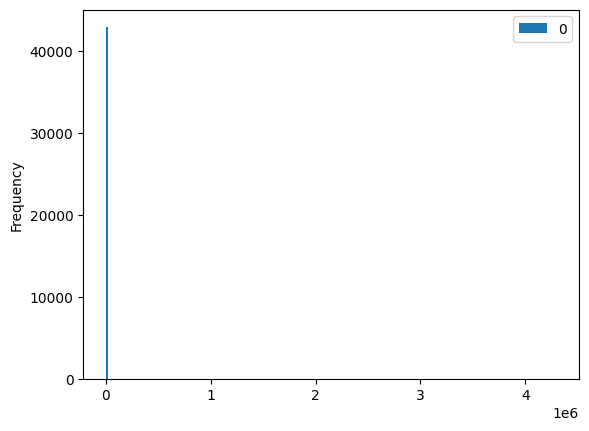

In [89]:
print(pd.DataFrame(distances).describe())
pd.DataFrame(distances).plot.hist(bins=200)


So the model performs quite well on average, however we notice the distribution beiing extremely skweed. There are a few outliers where the prediction is way off, these are likely trips which were underrepresented in the data set (as noted earlier).

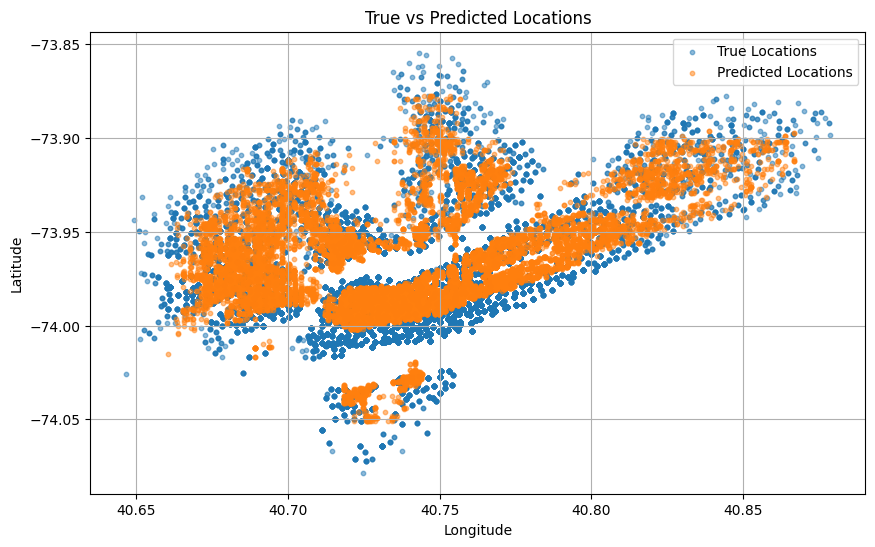

In [41]:
# plot predictions with accuracy up to 2km
import matplotlib.pyplot as plt
true_locs = geo_scaler.inverse_transform(y_test[(distances < 2000).values[:,0]])
pred_locs = geo_scaler.inverse_transform(preds[(distances < 2000).values[:,0]])

plt.figure(figsize=(10, 6))
plt.scatter(x=true_locs[:,0], y=true_locs[:,1], label='True Locations', alpha=0.5, s=10)
plt.scatter(x=pred_locs[:,0], y=pred_locs[:,1], label='Predicted Locations', alpha=0.5, s=10)
plt.title('True vs Predicted Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid()
plt.show()